In [11]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [12]:
#GNNs
df = pd.read_csv("Test_train_outputs.csv")
df = df.dropna()
heights = df.loc[:,'target']
weights = df.loc[:,'prediction']

df1 = pd.read_csv("Test_val_outputs.csv")
df1 = df1.dropna()
heights1 = df1.loc[:,'target']
weights1 = df1.loc[:,'prediction']

df2 = pd.read_csv("Test_test_outputs.csv")
df2 = df2.dropna()
heights_2 = df2.loc[:,'target']
weights_2 = df2.loc[:,'prediction']

weights = pd.concat([weights1, weights], ignore_index=True)
heights = pd.concat([heights1, heights], ignore_index=True)

In [15]:
#XGBoost
df = pd.read_csv("Test_train_outputs-XGBoost.csv")
df = df.dropna()
heights = df.loc[:,'target']
weights = df.loc[:,'prediction']

df1 = pd.read_csv("Test_test_outputs-XGBoost.csv")
df1 = df1.dropna()
heights_2 = df1.loc[:,'target']
weights_2 = df1.loc[:,'prediction']

In [20]:
#Gaussian Process
df = pd.read_csv("Test_train_outputs-GP.csv")
df = df.dropna()
heights = df.loc[:,'target']
weights = df.loc[:,'prediction']

df1 = pd.read_csv("Test_test_outputs-GP.csv")
df1 = df1.dropna()
heights_2 = df1.loc[:,'target']
weights_2 = df1.loc[:,'prediction']

In [4]:
#Other
df = pd.read_csv("C:/Users/nfurth/Desktop/Test_train_outputs.csv")
df = df.dropna()
heights = df.loc[:,'target']
weights = df.loc[:,'prediction']

df1 = pd.read_csv("C:/Users/nfurth/Desktop/Test_test_outputs.csv")
df1 = df1.dropna()
heights_2 = df1.loc[:,'target']
weights_2 = df1.loc[:,'prediction']

In [5]:
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    if ax is None:
        ax = plt.gca() 
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor=['None'])
    return ax

def plot_ci_bootstrap(xs, ys, resid, nboot=500, ax=None):
    if ax is None:
        ax = plt.gca()
    bootindex = sp.random.randint
    for _ in range(nboot):
        resamp_resid = resid[bootindex(0, len(resid) - 1, len(resid))]
        # Make coeffs of for polys
        pc = sp.polyfit(xs, ys + resamp_resid, 1)                   
        # Plot bootstrap cluster
        ax.plot(xs, sp.polyval(pc, xs), "b-", linewidth=2, alpha=3.0 / float(nboot))
    return ax

# Modeling with Numpy
def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

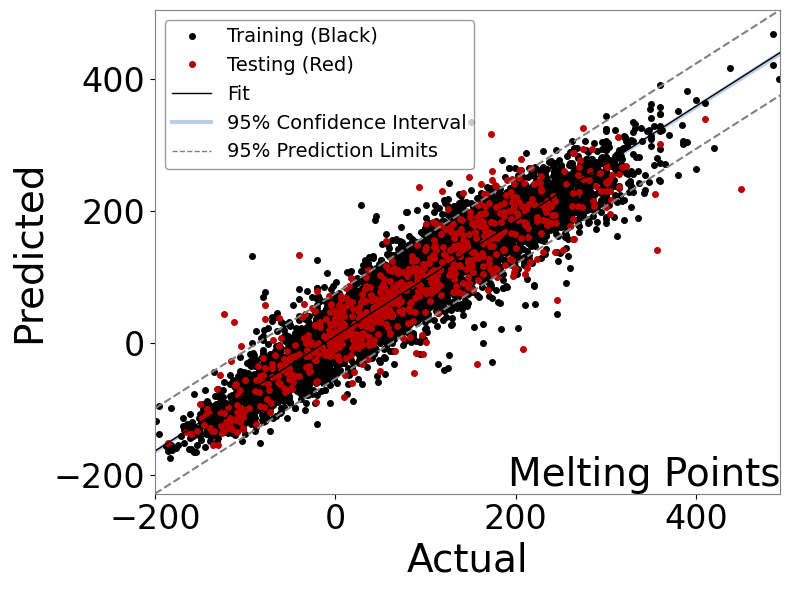

In [14]:
# Computations ----------------------------------------------------------------    
x, y, x_2, y_2 = heights, weights, heights_2, weights_2

p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = weights.size                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                                        # residuals; diff. actual data from predicted values
chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    x, y, "o", color="black", markersize=4, 
    markeredgewidth=1, markeredgecolor="black", markerfacecolor="black",
    label='Training (Black)')

ax.plot(
    x_2, y_2, "o", color="#b80000", markersize=4, 
    markeredgewidth=1, markeredgecolor="#b80000", markerfacecolor="#b80000",
    label='Testing (Red)')

plt.margins(y=0)
plt.margins(x=0)

# Fit --------------------------------------------------------------------
x_fit = np.linspace(np.min(x) - 1, np.max(x) + 1, 100)
y_fit = equation(p, x_fit)

ax.plot(x_fit, y_fit, "-", color="0", linewidth=1, alpha=1, label="Fit")  

x2 = np.linspace(np.min(x) - 1, np.max(x) + 1, 100)
y2 = equation(p, x2)

# Confidence Interval --------------------------------------------------------------------
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
ci_handle = plt.Line2D([], [], color='#B9CFE7', linewidth=3, linestyle='-', label='95% Confidence Interval')

# Prediction Interval --------------------------------------------------------------------
pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
pi_handle = plt.Line2D([], [], color='0.5', linewidth=1, linestyle='--', label='95% Prediction Limits')

ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
ax.plot(x2, y2 + pi, "--", color="0.5")
#plt.show()

#Figure Modifications --------------------------------------------------------
#Borders ---------------------------------------------------------------------
ax.spines["top"].set_color("0.5")
ax.spines["bottom"].set_color("0.5")
ax.spines["left"].set_color("0.5")
ax.spines["right"].set_color("0.5")

ax.get_xaxis().set_tick_params(direction="out", )
ax.get_yaxis().set_tick_params(direction="out")

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='y', which='major', labelsize=24)

#Labels --------------------------------------------------------------------
ax.set_xlabel("Actual", fontsize=28)
ax.set_ylabel("Predicted", fontsize=28)

log = 0

if log == 1:
    xticks = np.linspace(0, 6, 7)
    yticks = np.linspace(0, 6, 7)
    ax.set_ylim(-1, 7)
    ax.set_xlim(-1, 7)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

#Tranform from logscale
if log == 1:
    xticks_transformed = [f'$10^{{{-int(x)}}}$' for x in xticks]
    yticks_transformed = [f'$10^{{{-int(y)}}}$' for y in yticks]

    ax.set_xticklabels(xticks_transformed)
    ax.set_yticklabels(yticks_transformed)

#Custom legend --------------------------------------------------------------------
handles, labels = ax.get_legend_handles_labels()

# Rearrange handles and labels
handles = [handles[0], handles[1], handles[2], ci_handle, pi_handle]
labels = [labels[0], labels[1], labels[2], ci_handle.get_label(), pi_handle.get_label()]

legend = ax.legend(handles, labels, fontsize=14, loc ="upper left")
frame = legend.get_frame().set_edgecolor("0.5")

plt.text(1, 0, 'Melting Points', ha='right', va='bottom', transform=ax.transAxes, fontsize=28)

# Save Figure
plt.tight_layout()
plt.savefig("my_plot.png", dpi=300)
plt.show()

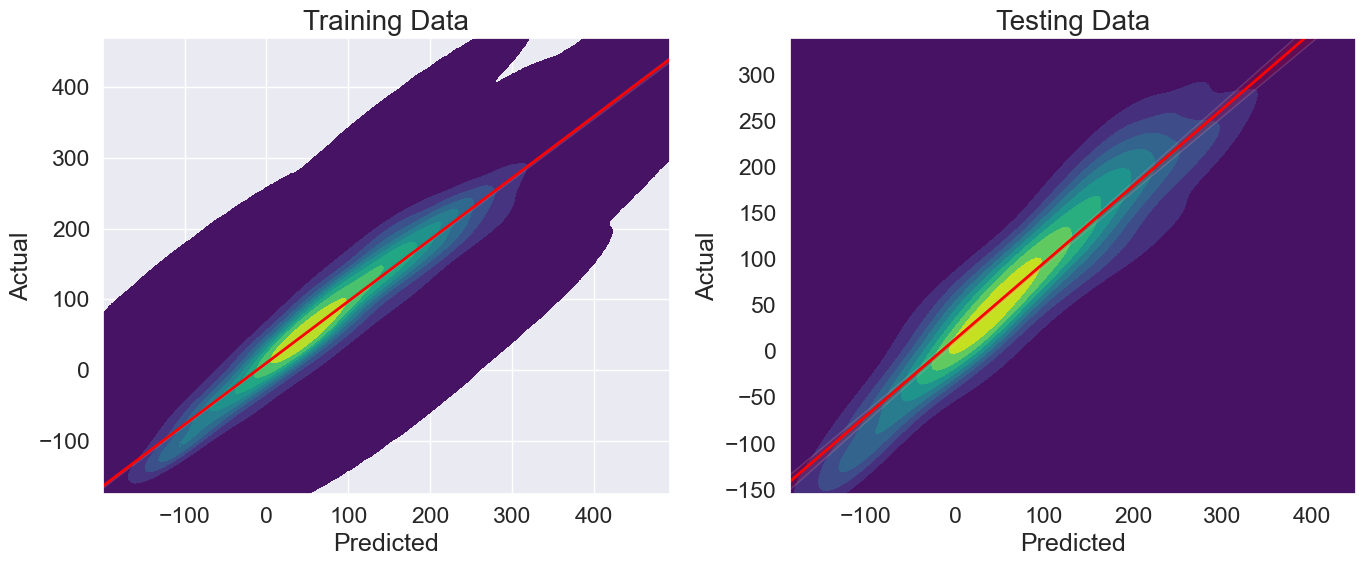

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming you have the data for training and testing in x, y, x_2, y_2

# Create subplots for training and testing
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Set a larger font size for everything
sns.set(font_scale=1.5)

# Plotting for Training Data
ax = axes[0]
sns.kdeplot(x=x, y=y, cmap="viridis", ax=ax, shade=True, cbar_kws={'label': 'Density'}, thresh=0)
sns.regplot(x=x, y=y, scatter=False, ax=ax, color='red', line_kws={'linewidth': 2})
ax.set_xlabel("Predicted", fontsize=18)
ax.set_ylabel("Actual", fontsize=18)
ax.set_title("Training Data", fontsize=20)
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))
ax.locator_params(axis='x', nbins=10) 
ax.locator_params(axis='y', nbins=10)

# Plotting for Testing Data
ax = axes[1]
sns.kdeplot(x=x_2, y=y_2, cmap="viridis", ax=ax, shade=True, cbar_kws={'label': 'Density'}, thresh=0)
sns.regplot(x=x_2, y=y_2, scatter=False, ax=ax, color='red', line_kws={'linewidth': 2})
ax.set_xlabel("Predicted", fontsize=18)
ax.set_ylabel("Actual", fontsize=18)
ax.set_title("Testing Data", fontsize=20)
ax.set_xlim(min(x_2), max(x_2))
ax.set_ylim(min(y_2), max(y_2))
ax.locator_params(axis='x', nbins=10) 
ax.locator_params(axis='y', nbins=10)

plt.tight_layout()
plt.show()